**4th Notebook in analysis**

**Diversity analyses and omnibus tests for first part of paper**

In [1]:
import os, scipy
import numpy as np
from scipy.spatial.distance import pdist, squareform
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
%matplotlib inline
import seaborn as sns
from qiime2 import Artifact
from qiime2.plugins.diversity.pipelines import alpha_phylogenetic
from qiime2.plugins import feature_table,phylogeny
from qiime2.plugins.taxa.methods import collapse
from qiime2.plugins.diversity_lib.methods import weighted_unifrac
from skbio.stats.distance import permanova, DistanceMatrix, mantel
from skbio.stats.ordination import pcoa
from math import sin, cos, sqrt, atan2, radians
from Bio import Phylo
datapath = '../data'

# Read Data

In [2]:
# metadata
bombusMeta = pd.read_csv(os.path.join(datapath, 'bombusMetadata.tsv'), sep = '\t', index_col=0)
bombusMeta['caste'] = bombusMeta['caste'].replace('M ', 'M')
bombusMeta['Year'] = bombusMeta['Year'].astype('str')
bombusMeta['days_Since_May1']=bombusMeta['date_of_collection'].apply(lambda x: (pd.to_datetime(x) - 
                                                pd.to_datetime('5/1/' +str(pd.to_datetime(x).year) )).days)
## "there are no Bombus fervidus in the state of Maine"
bombusMeta['species'].replace({'fer':'bor'},
                             inplace = True)

# Feature Table
mt = Artifact.load(os.path.join(datapath, 'qiime', 'mt.qza'))
mt_rare = Artifact.load(os.path.join(datapath, 'qiime', 'mt_rare.qza'))
# level 6 feature table 
level6 = pd.read_csv(os.path.join(datapath,
                        'table/genus_table.tsv'), sep = '\t', index_col=0)
level6 = (level6/level6.sum()).transpose()
level3 = pd.read_csv(os.path.join(datapath,
                        'table/class_table.tsv'), sep = '\t', index_col=0)
level3 = (level3/level3.sum()).transpose()
#Tree
rooted_tree=Artifact.load(os.path.join(datapath, 'qiime/rooted_tree.qza'))
#Taxa
taxa = pd.read_csv(os.path.join(datapath, 'table/ensemble_taxa.tsv'), sep = '\t',
                   index_col=0)

## filter non-sequenced samples out of metadata
bombusMeta = bombusMeta.loc[level6.index]

/var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/ipykernel_5833/3447832733.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bombusMeta['species'].replace({'fer':'bor'},


# OTU and host species prevalence views

## sample species barplot 

**count table**

In [97]:
counts = pd.pivot(pd.DataFrame(bombusMeta.groupby('caste')['species'].value_counts()\
).reset_index(), index='caste', columns='species',
         values='count').fillna(0)
counts.loc['totals'] = counts.sum()
counts['totals'] = counts.sum(axis=1)
counts

species,bim,bor,gris,imp,per,ruf,san,tern,terri,vag,totals
caste,,,,,,,,,,,
M,25.0,26.0,0.0,5.0,4.0,2.0,0.0,3.0,4.0,19.0,88.0
Q,8.0,8.0,1.0,14.0,0.0,0.0,1.0,9.0,1.0,3.0,45.0
W,128.0,40.0,0.0,82.0,4.0,12.0,6.0,126.0,24.0,83.0,505.0
totals,161.0,74.0,1.0,101.0,8.0,14.0,7.0,138.0,29.0,105.0,638.0


In [31]:
plotdf = bombusMeta[['species', 'caste', 'Year']].copy()
plotdf['count'] = plotdf['species'] + '-' +plotdf['caste'] +'-'+plotdf['Year']
plotdf = pd.DataFrame(plotdf['count'].value_counts())
plotdf['species'] = plotdf.index
plotdf['caste'] = plotdf['species'].apply(lambda x: x.split('-')[1])
plotdf['Year'] =plotdf['species'].apply(lambda x: x.split('-')[2])
plotdf['species'] =plotdf['species'].apply(lambda x: x.split('-')[0])
                                          

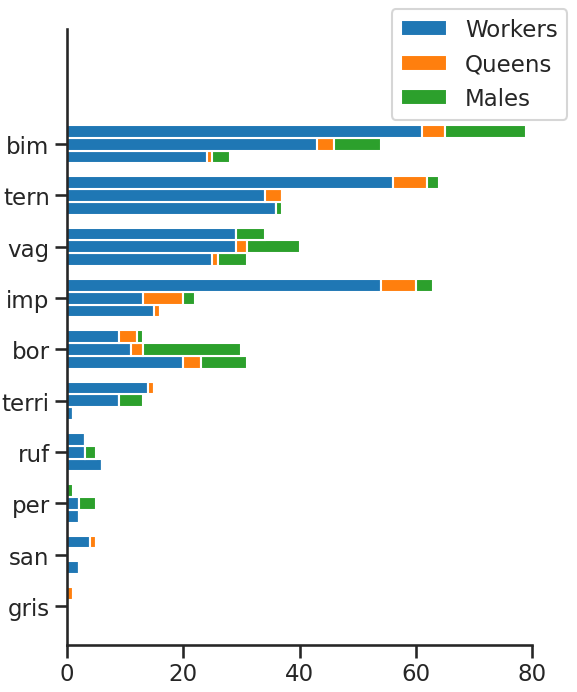

In [28]:
# y axis: species and year
# x axis: blocks by caste 
data_dict = {'2017': {'W': [],
                     'M': [],
                     'Q': []},
            '2018': {'W': [],
                     'M': [],
                     'Q': []},
            '2019': {'W': [],
                     'M': [],
                     'Q': []}}

species = plotdf.groupby('species')['count'].sum().sort_values(ascending = True).index.to_list()
for s in species:
    for year in ['2017', '2018', '2019']:
        for caste in ['W', 'M', 'Q']:
            if s+'-'+caste+'-'+year in plotdf.index:
                data_dict[year][caste].append(plotdf.loc[s+'-'+caste+'-'+year, 'count'])
            else: data_dict[year][caste].append(0)
                    

                
with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")   
    fig, ax = plt.subplots(figsize = (6, 8))

    # plot details
    bar_width = 0.25
    epsilon = .015
    line_width = 1
    opacity = 0.7
    s17_bar_positions = np.arange(len(species))
    s18_bar_positions = s17_bar_positions + bar_width
    s19_bar_positions = s18_bar_positions + bar_width
    
    s17_worker_bars = plt.barh( s17_bar_positions, data_dict['2017']['W'], bar_width,
                              color='C0')
    s17_queen_bars = plt.barh(s17_bar_positions, data_dict['2017']['Q'], bar_width,
                              left=data_dict['2017']['W'],
                              color='C1')
    s17_male_bars = plt.barh(s17_bar_positions, data_dict['2017']['M'], bar_width,
                              left=np.array(data_dict['2017']['W']) + np.array(data_dict['2017']['Q']),
                              color='C2')
    
    s18_worker_bars = plt.barh( s18_bar_positions, data_dict['2018']['W'], bar_width,
                              color='C0')
    s18_queen_bars = plt.barh(s18_bar_positions, data_dict['2018']['Q'], bar_width,
                              left=data_dict['2018']['W'],
                              color='C1')
    s18_male_bars = plt.barh(s18_bar_positions, data_dict['2018']['M'], bar_width,
                              left=np.array(data_dict['2018']['W']) + np.array(data_dict['2018']['Q']),
                              color='C2')
    
    s19_worker_bars = plt.barh( s19_bar_positions, data_dict['2019']['W'], bar_width,
                              color='C0',
                              label='Workers')
    s19_queen_bars = plt.barh(s19_bar_positions, data_dict['2019']['Q'], bar_width,
                              left=data_dict['2019']['W'],
                              color='C1',
                              label='Queens')
    s19_male_bars = plt.barh(s19_bar_positions, data_dict['2019']['M'], bar_width,
                              left=np.array(data_dict['2019']['W']) + np.array(data_dict['2019']['Q']),
                              color='C2',
                              label='Males')
    plt.xlim(0,80)
    plt.ylim(-.5,11.5)
    
    plt.yticks(s18_bar_positions, species, rotation=0)
    plt.legend(bbox_to_anchor=(1.1, 1.05)) 
    sns.despine()
    #plt.show()
    plt.savefig('figs/species_counts_per_year.pdf',
               format = 'pdf', transparent = True, bbox_inches='tight')

## Core genus prev table

In [23]:
core_prev_counts = bombusMeta[['species', 'caste']].join(level6[[x for\
                x in level6.columns if any(y in x for y in ['Snod', 'Gillia',
            'Lactobacillus', 'Bifidobacterium', 'Bombiscar', 'Schmid', 'Apibac'])]].rename(\
            columns = dict(zip([x for x in level6.columns if any(y in x for y in ['Snod', 'Gillia',
            'Lactobacillus', 'Bifidobacterium', 'Bombiscar', 'Schmid', 'Apibac'])],
        [x.split('g__')[1] for x in level6.columns if any(y in x for y in ['Snod', 'Gillia',
            'Lactobacillus', 'Bifidobacterium', 'Bombiscar', 'Schmid', 'Apibac'])]))) >0)

temp = core_prev_counts.copy()
temp['caste'] = 'Z'
prev_table = pd.concat([core_prev_counts, temp]).groupby(['species',
    'caste']).sum().join(pd.concat([core_prev_counts, temp]).groupby(['species',
                    'caste']).mean().apply(lambda x: \
        round(x*100)).rename(columns = dict(zip(core_prev_counts.columns[2:],
            core_prev_counts.columns[2:]+'%'))))[sorted(list(core_prev_counts.columns[2:]) +\
           list(core_prev_counts.columns[2:]+'%'))]
prev_table.to_csv(os.path.join(datapath,
        'table', 'prev_table.tsv'), sep = '\t')
prev_table

Apibacter  Apibacter%  Bifidobacterium  Bifidobacterium%  \
species caste                                                             
bim     M              8        32.0               10              40.0   
        Q              2        25.0                3              38.0   
        W             42        33.0               35              27.0   
        Z             52        32.0               48              30.0   
bor     M             11        42.0               21              81.0   
        Q              5        62.0                8             100.0   
        W             21        52.0               28              70.0   
        Z             37        50.0               57              77.0   
gris    Q              1       100.0                1             100.0   
        Z              1       100.0                1             100.0   
imp     M              5       100.0                3              60.0   
        Q              2        14.0                2              14.0   
        W             61        74.0               55              67.0   
        Z             68        67.0               60              59.0   
per     M              2        50.0                4             100.0   
        W              0         0.0                1              25.0   
        Z              2        25.0                5              62.0   
ruf     M              1        50.0                2             100.0   
        W              5        42.0                6              50.0   
        Z              6        43.0                8              57.0   
san     Q              0         0.0                0               0.0   
        W              2        33.0                2              33.0   
        Z              2        29.0                2              29.0   
tern    M              1        33.0                1              33.0   
        Q              4        44.0                3              33.0   
        W             58        46.0               27              21.0   
        Z             63        46.0               31              22.0   
terri   M              0         0.0                3              75.0   
        Q              1       100.0                1             100.0   
        W              8        33.0               15              62.0   
        Z              9        31.0               19              66.0   
vag     M              0         0.0                6              32.0   
        Q              1        33.0                1              33.0   
        W             16        19.0               16              19.0   
        Z             17        16.0               23              22.0   

               Bombiscardovia  Bombiscardovia%  Gilliamella  Gilliamella%  \
species caste                                                               
bim     M                  15             60.0           25         100.0   
        Q                   6             75.0            7          88.0   
        W                  93             73.0          123          96.0   
        Z                 114             71.0          155          96.0   
bor     M                   1              4.0           26         100.0   
        Q                   4             50.0            8         100.0   
        W                  16             40.0           40         100.0   
        Z                  21             28.0           74         100.0   
gris    Q                   1            100.0            1         100.0   
        Z                   1            100.0            1         100.0   
imp     M                   4             80.0            5         100.0   
        Q                   6             43.0           13          93.0   
        W                  60             73.0           81          99.0   
        Z                  70             69.0           99          98.0   
per    

## OTU prev vs abund

convert feature table to pd. dataframe

In [98]:
mt = mt.view(pd.DataFrame)
mt_rel = (mt.transpose()/mt.sum(axis=1)).transpose()

samples where OTUs are found vs non-zero mena relative abundance

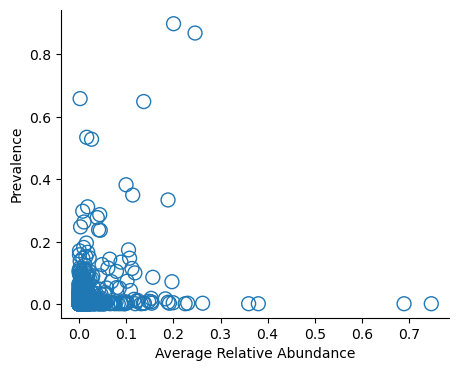

In [33]:
fig, ax = plt.subplots(figsize = (5,4))
plotdf = pd.DataFrame({'Mean':mt_rel.replace(0, np.nan).mean(),
              'Prev':(mt_rel >0).mean()})

plt.scatter(x = plotdf['Mean'], y = plotdf['Prev'],
               facecolors="none", edgecolor = 'C0', s = 100, alpha =1)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Average Relative Abundance')
plt.ylabel('Prevalence')
sns.despine()
plt.savefig('figs/OTU_prev_abund.pdf',
               format = 'pdf', transparent = True, 
           bbox_inches="tight" )

In [33]:
print('OTUs found in more than 1 sample at more than 1% RA:',
      plotdf[(plotdf['Mean'] > 0.01) & (plotdf['Prev'] > 1/638)].shape[0])

OTUs found in more than 1 sample at more than 1% RA: 172


# Calculate Diversity

## Alpha diversity (faith pd)

**calc with qiime, add to metadata**

In [99]:
faithpd = alpha_phylogenetic(table = mt_rare, phylogeny = rooted_tree, metric ='faith_pd')
bombusMeta['faithpd'] = faithpd.alpha_diversity.view(pd.Series)

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/qiime2/markyoung/data/a3fb131b-4068-4c1b-bc91-ed43aea56955/data/feature-table.biom -t /var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/qiime2/markyoung/data/35876f5c-5417-4221-bf1a-99b079937b5e/data/tree.nwk -o /var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/qiime2/markyoung/processes/65974-1742415448.493148@markyoung/tmp/q2-OutPath-4yxovjfa



/Users/markyoung/miniforge3/envs/bombus/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')


/Users/markyoung/miniforge3/envs/bombus/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='faithpd', ylabel='Count'>

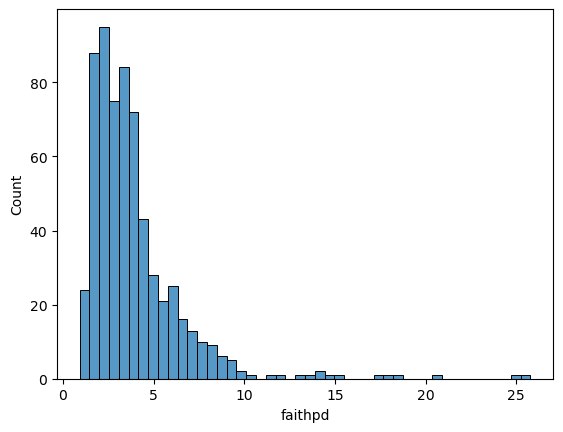

In [5]:
sns.histplot(bombusMeta, x = 'faithpd')

## beta diversity (unifrac)

**calculate with qiime2**

In [100]:
wu_df = weighted_unifrac(table = Artifact.load(os.path.join(datapath, 'qiime', 'mt.qza')), 
                phylogeny = Artifact.load(os.path.join(datapath, 'qiime', 'rooted_tree.qza')),
                threads =2)
wu_df = wu_df.distance_matrix.view(DistanceMatrix).to_data_frame()
# save 
wu_df.to_csv(os.path.join(datapath, 'dm/wudf.csv'))

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/qiime2/markyoung/data/cc69364a-1bc6-429f-a1ac-a4bc30699581/data/feature-table.biom -t /var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/qiime2/markyoung/data/35876f5c-5417-4221-bf1a-99b079937b5e/data/tree.nwk -m weighted_unnormalized -o /var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/qiime2/markyoung/processes/65974-1742415448.493148@markyoung/tmp/q2-OutPath-3e7rfhul



**use for pcoa**

In [101]:
weightedpc = pcoa(wu_df)
bombusMeta = bombusMeta.join(weightedpc.samples[['PC1', 'PC2']].set_index(wu_df.index))

/Users/markyoung/miniforge3/envs/bombus/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.5666177343670172 and the largest is 12.008530892466451.
  warn(


ValueError: columns overlap but no suffix specified: Index(['PC1', 'PC2'], dtype='object')

In [102]:
weightedpc.proportion_explained[:2]

PC1    0.296334
PC2    0.181105
dtype: float64

## look at top taxa by relative abundance

### top taxa by sample /site

In [42]:
level3.median().sort_values()[-5:]

Taxon
d__Bacteria;p__Bacillota;c__Bacilli                     0.001019
d__Bacteria;p__Pseudomonadota;c__Alphaproteobacteria    0.001526
d__Bacteria;p__Actinomycetota;c__Actinomycetes          0.003324
d__Bacteria;p__Pseudomonadota;c__Betaproteobacteria     0.146737
d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria    0.569176
dtype: float64

In [47]:
level6.mean().sort_values()[-5:]

Taxon
d__Bacteria;p__Pseudomonadota;c__Alphaproteobacteria;o__Hyphomicrobiales;f__Brucellaceae;g__Brucella          0.040306
d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Entomomonas    0.065238
d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Orbales;f__Orbaceae;g__Schmidhempelia                 0.193116
d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Orbales;f__Orbaceae;g__Gilliamella                    0.196795
d__Bacteria;p__Pseudomonadota;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Snodgrassella         0.271496
dtype: float64

**other way of thinking about it: each bee is a sample from the same site:trip microbiome**

In [182]:
bombusMeta['site_trip'] = bombusMeta['site_collapsed'] + bombusMeta['date_of_collection']

In [45]:
site_trip_means = pd.DataFrame(columns = level6.columns)
for s in bombusMeta['site_trip'].unique():
    site_trip_means.loc[s] = level6.loc[bombusMeta[bombusMeta['site_trip'] == s].index].mean()

In [46]:
site_trip_means.mean().sort_values().iloc[-8:]

Taxon
d__Bacteria;p__Bacillota;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Fructobacillus                       0.015138
d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Stenotrophomonas    0.016001
d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Entomomonas         0.043234
d__Bacteria;p__Bacteroidota;c__Flavobacteriia;o__Flavobacteriales;f__Weeksellaceae;g__Apibacter                    0.044989
d__Bacteria;p__Pseudomonadota;c__Alphaproteobacteria;o__Hyphomicrobiales;f__Brucellaceae;g__Brucella               0.056937
d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Orbales;f__Orbaceae;g__Schmidhempelia                      0.202486
d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Orbales;f__Orbaceae;g__Gilliamella                         0.214825
d__Bacteria;p__Pseudomonadota;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Snodgrassella              0.257210
dt

**relative abundance plot for top 10 taxa**

['g__Fructobacillus',
 'g__Rosenbergiella',
 'g__Acinetobacter',
 'f__Enterobacteriaceae',
 'g__Apibacter',
 'g__Brucella',
 'g__Entomomonas',
 'g__Schmidhempelia',
 'g__Gilliamella',
 'g__Snodgrassella']

/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


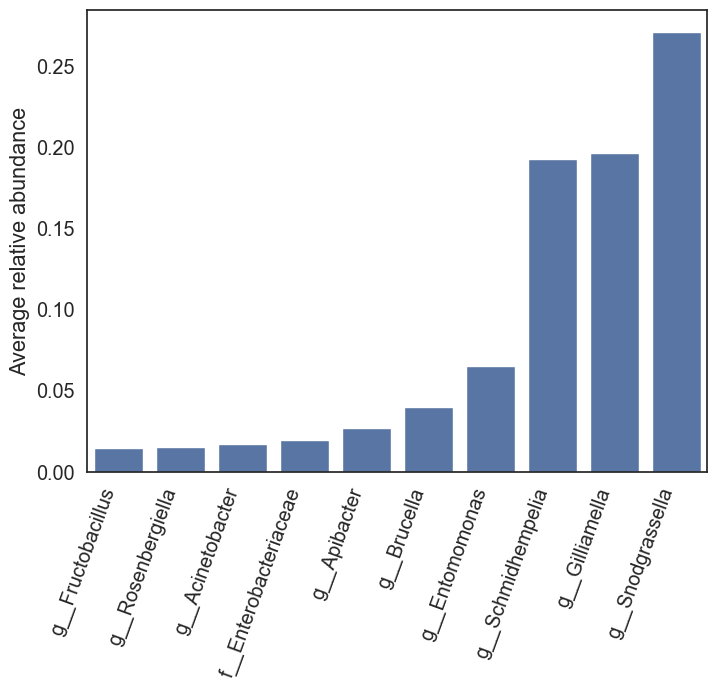

In [52]:
sns.set(font_scale=1.3, style ='white')
fig, ax = plt.subplots(figsize = (8,6))
sns.barplot(x = list(map(lambda x: x.split(';')[-1], level6.mean().sort_values()[-10:].index)),
            y = level6.mean().sort_values()[-10:], color = 'C0', ax = ax)
plt.xticks(rotation = 70, ha='right')
plt.ylabel('Average relative abundance')
#plt.show()
plt.savefig('figs/avg_ra_top_taxa.pdf', transparent = True)

In [53]:
print('average of top 3:', 100*level6.mean().sort_values()[-3:].sum())

average of top 3: 66.1406922503203


### look for correlations 

In [54]:
level3.mean().sort_values()

Taxon
d__Bacteria;p__Actinomycetota;c__Coriobacteriia         1.333269e-08
d__Bacteria;p__Pseudomonadota;c__Magnetococcia          6.542957e-08
d__Bacteria;p__Omnitrophota;c__Koll11                   1.005419e-07
d__Bacteria;p__Planctomycetota;c__GCA-002687715         1.508129e-07
d__Bacteria;p__Acidobacteriota;c__UBA890                2.010838e-07
                                                            ...     
d__Bacteria;p__Bacillota;c__Bacilli                     2.485019e-02
d__Bacteria;p__Bacteroidota;c__Flavobacteriia           2.881843e-02
d__Bacteria;p__Pseudomonadota;c__Alphaproteobacteria    8.046933e-02
d__Bacteria;p__Pseudomonadota;c__Betaproteobacteria     2.765594e-01
d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria    5.600479e-01
Length: 77, dtype: float64

In [56]:
bombusMeta = bombusMeta.join(level3[['d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria',
                       'd__Bacteria;p__Pseudomonadota;c__Alphaproteobacteria',
                       'd__Bacteria;p__Pseudomonadota;c__Betaproteobacteria']].rename(columns = \
    dict(zip(['d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria',
                       'd__Bacteria;p__Pseudomonadota;c__Alphaproteobacteria',
                       'd__Bacteria;p__Pseudomonadota;c__Betaproteobacteria'],
            ['Gammaproteobacteria','Alphaproteobacteria', 'Betaproteobacteria' ]))))

bombusMeta = bombusMeta.join(level6[[x for x in level6.columns if any(y in x for y in ['Snod', 'Gillia',
            'Lactobacillus', 'Bifidobacterium', 'Bombiscar', 'Schmid', 'Apibac'])]]).rename(\
            columns = dict(zip([x for x in level6.columns if any(y in x for y in ['Snod', 'Gillia',
            'Lactobacillus', 'Bifidobacterium', 'Bombiscar', 'Schmid', 'Apibac'])],
        [x.split('g__')[1] for x in level6.columns if any(y in x for y in ['Snod', 'Gillia',
            'Lactobacillus', 'Bifidobacterium', 'Bombiscar', 'Schmid', 'Apibac'])])))

#bombusMeta.rename(columns = {'Candidatus_Schmidhempelia': 'Schmidhempelia'}, inplace = True)

bombusMeta['core'] = bombusMeta[['Snodgrassella', 'Gilliamella', 'Lactobacillus',
                        'Bifidobacterium','Bombiscardovia',
           'Schmidhempelia','Apibacter' ]].sum(axis=1)

bombusMeta['Pseudomonadota'] = bombusMeta[['Gammaproteobacteria','Alphaproteobacteria', 'Betaproteobacteria' ]].sum(axis=1)

**Spearman correlations between top taxa and faith pd**

In [61]:
bombusMeta[bombusMeta.columns[-16:]].drop(columns = ['site_trip',
         'PC1', 'PC2']).corr(method ='spearman').sort_values(by = 'faithpd')

,faithpd,Gammaproteobacteria,Alphaproteobacteria,Betaproteobacteria,Bifidobacterium,Bombiscardovia,Lactobacillus,Apibacter,Snodgrassella,Gilliamella,Schmidhempelia,core,Pseudomonadota
core,-0.475001,-0.121963,-0.655720,0.512574,0.098389,0.310983,0.166887,0.219934,0.570196,0.476065,0.219929,1.000000,0.111750
Snodgrassella,-0.283959,-0.608587,-0.377534,0.970140,0.203673,0.427923,0.201643,0.038659,1.000000,0.348003,-0.256040,0.570196,-0.020438
Betaproteobacteria,-0.251354,-0.681664,-0.304587,1.000000,0.171274,0.405802,0.169889,0.000859,0.970140,0.296656,-0.300418,0.512574,-0.014562
Gilliamella,-0.218828,0.028166,-0.332710,0.296656,0.316549,0.143189,0.284900,0.354020,0.348003,1.000000,-0.046006,0.476065,-0.153259
Pseudomonadota,-0.216809,0.290164,-0.137632,-0.014562,-0.337951,-0.145780,-0.382925,-0.475515,-0.020438,-0.153259,0.045073,0.111750,1.000000
Bombiscardovia,-0.109057,-0.245452,-0.165467,0.405802,-0.002517,1.000000,-0.028914,0.017600,0.427923,0.143189,0.008946,0.310983,-0.145780
Schmidhempelia,0.003554,0.444363,-0.076373,-0.300418,-0.105742,0.008946,0.004821,0.118791,-0.256040,-0.046006,1.000000,0.219929,0.045073
Apibacter,0.044551,0.026009,-0.121760,0.000859,0.259394,0.017600,0.364144,1.000000,0.038659,0.354020,0.118791,0.219934,-0.475515
Gammaproteobacteria,0.072034,1.000000,-0.118117,-0.681664,-0.022757,-0.245452,-0.055642,0.026009,-0.608587,0.028166,0.444363,-0.121963,0.290164
Bifidobacterium,0.090212,-0.022757,-0.071105,0.171274,1.000000,-0.002517,0.559211,0.259394,0.203673,0.316549,-0.105742,0.098389,-0.337951


Alphaproteobacteria vs faith pd is pretty significant

In [71]:
scipy.stats.spearmanr(bombusMeta[['Betaproteobacteria', 'faithpd']].dropna()['Betaproteobacteria'],
                      bombusMeta[['Betaproteobacteria', 'faithpd']].dropna()['faithpd'])

SignificanceResult(statistic=-0.2513539283103937, pvalue=1.5084279011504814e-10)

**Plot on weighted unifrac PcoA**

In [49]:
bombusMeta[['faithpd']].join(pd.DataFrame(bombusMeta[['Gammaproteobacteria', 'Betaproteobacteria']].sum(axis=1))).corr(method='spearman')

,faithpd,0
faithpd,1.000000,-0.370812
0,-0.370812,1.000000


/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

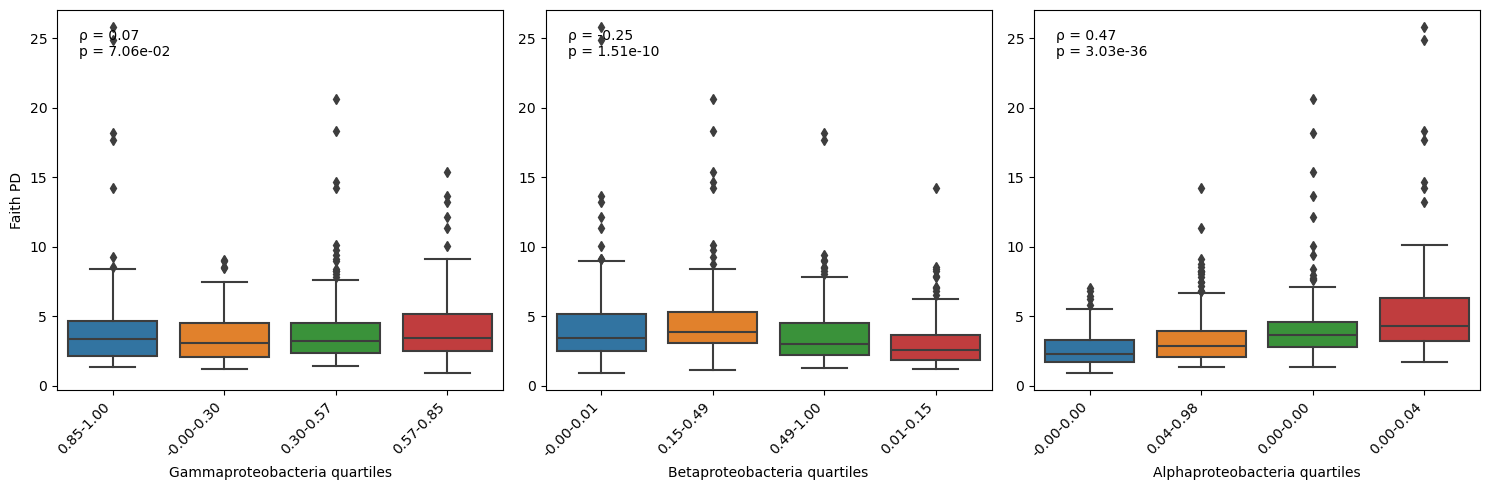

In [94]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
proteobacteria = ['Gammaproteobacteria', 'Betaproteobacteria', 'Alphaproteobacteria']

for i, bacteria in enumerate(proteobacteria):
    # Create bins based on abundance
    bombusMeta['abundance_bin'] = pd.qcut(bombusMeta[bacteria], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    
    # Create boxplot with 8 bins and range labels
    bins = pd.qcut(bombusMeta[bacteria], q=4)
    bombusMeta['abundance_bin'] = bins
    sns.boxplot(data=bombusMeta, x='abundance_bin', y='faithpd', ax=axes[i])
    # Format x-axis labels to show ranges
    labels = [f'{interval.left:.2f}-{interval.right:.2f}' for interval in bins.unique()]
    axes[i].set_xticklabels(labels, rotation=45, ha='right')
    
    # Add labels
    axes[i].set_xlabel(f'{bacteria} quartiles')
    if i == 0:
        axes[i].set_ylabel('Faith PD')
    else:
        axes[i].set_ylabel('')
        
    # Calculate and add correlation coefficient
    corr = scipy.stats.spearmanr(bombusMeta[bacteria], bombusMeta['faithpd'], 
                                nan_policy='omit')
    corr_text = f'ρ = {corr[0]:.2f}\np = {corr[1]:.2e}'
    axes[i].text(0.05, 0.95, corr_text, transform=axes[i].transAxes,
                fontsize=10, verticalalignment='top')

plt.tight_layout()


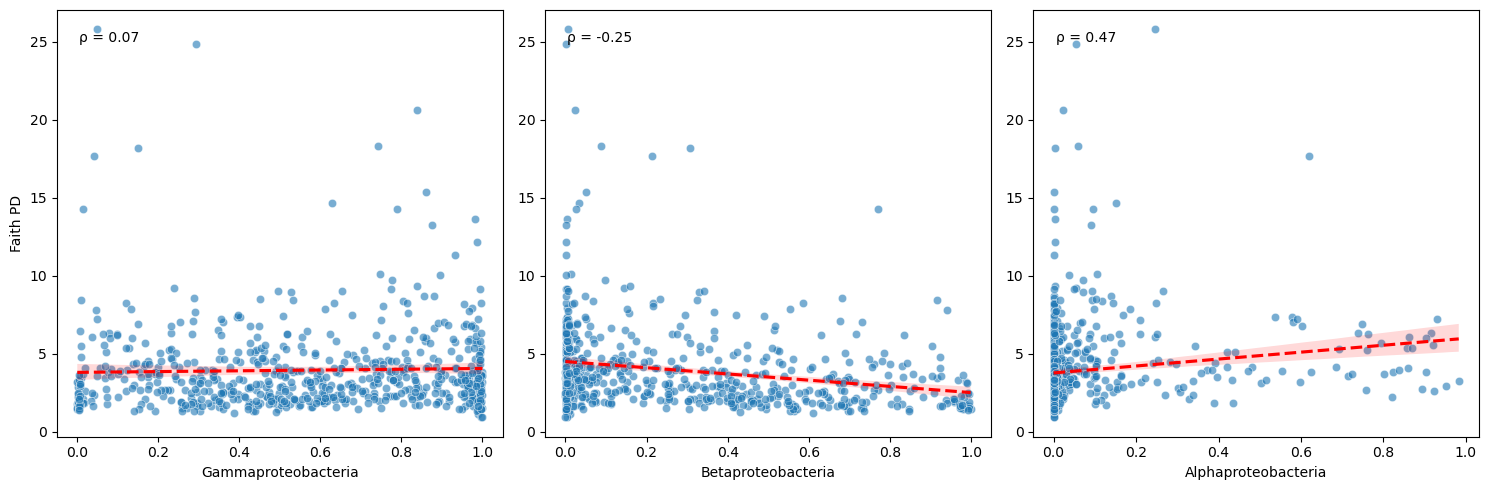

In [150]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
proteobacteria = ['Gammaproteobacteria', 'Betaproteobacteria', 'Alphaproteobacteria']

for i, bacteria in enumerate(proteobacteria):
    # Calculate correlation coefficient
    corr = scipy.stats.spearmanr(bombusMeta[bacteria], bombusMeta['faithpd'],
                                 nan_policy='omit')[0]
    corr_text = f'ρ = {corr:.2f}'
    
    # Create scatter plot
    bombusMeta['b'] = bombusMeta[bacteria].replace(0, bombusMeta[bombusMeta[bacteria] > 0][bacteria].min()/2)
    bombusMeta['b'] = np.log(bombusMeta['b'])
    sns.scatterplot(data=bombusMeta, x=bacteria, y='faithpd', ax=axes[i], alpha=0.6)
    xticks = axes[i].get_xticks()
    labels = [f'{10**x:.2e}' for x in xticks]

    # if bombusMeta[bombusMeta[bacteria]==0].shape[0] > 0:
    #     axes[i].axvline(x=bombusMeta[bacteria].min()+.3, color='black', linestyle='--')
    #     labels[0] = 'n.d.'
    #     xticks[0] = bombusMeta['b'].min()+.3
    
    # axes[i].set_xticks(xticks, labels)
   
    # Add trend line
    sns.regplot(data=bombusMeta, x=bacteria, y='faithpd', ax=axes[i], 
               scatter=False, color='red', line_kws={'linestyle':'--'})
    
    # Add correlation text
    axes[i].text(0.05, 0.95, corr_text, transform=axes[i].transAxes, 
                 fontsize=10, verticalalignment='top')
    
    # Format axes
    axes[i].set_xlabel(bacteria)
    if i == 0:
        axes[i].set_ylabel('Faith PD')
    else:
        axes[i].set_ylabel('')

plt.tight_layout()
plt.savefig('figs/class_vs_faith.pdf', transparent = True,
           bbox_inches="tight" )

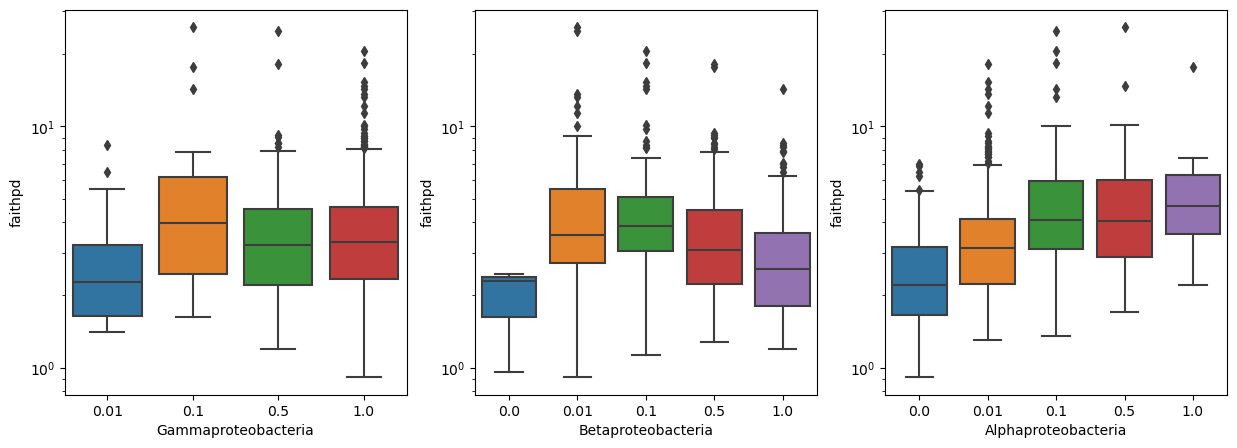

In [110]:
bins = [0, .01,.10,.50,1.00]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

proteobacteria = ['Gammaproteobacteria', 'Betaproteobacteria', 'Alphaproteobacteria']
for i, bacteria in enumerate(proteobacteria):
    axes[i].set_yscale('log')
    bombusMeta['bin'] = -1.0
    for b in bins:
        bombusMeta.loc[bombusMeta[(bombusMeta[bacteria] <= b) & (bombusMeta['bin'] == -1)].index, 'bin'] = b
    sns.boxplot(data = bombusMeta, x = 'bin', y = 'faithpd', ax = axes[i])
    axes[i].set_xlabel(bacteria)


/Users/Mark/mambaforge/envs/bombus_toshare/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='core', ylabel='Count'>

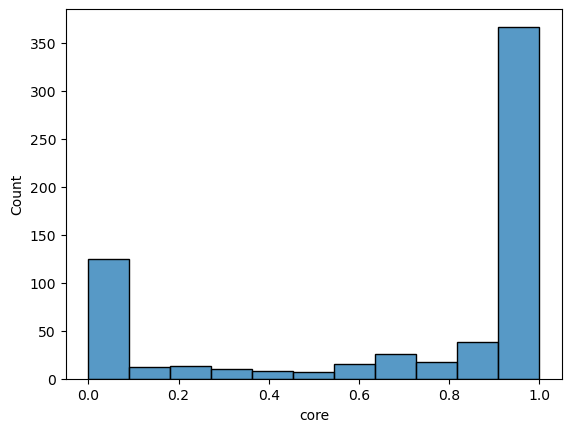

In [140]:
sns.histplot(bombusMeta['core'])

In [148]:
level6.loc[bombusMeta[bombusMeta['core']<.1].index].median().sort_values()

Taxon
d__Bacteria;p__Desulfobacterota;c__Deltaproteobacteria;o__Desulfuromonadales;f__Geobacteraceae;g__Geomonas               0.000000
d__Bacteria;p__Pseudomonadota;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Yoonia                    0.000000
d__Bacteria;p__Pseudomonadota;c__Alphaproteobacteria;o__Rhodobacterales;f__Roseobacteraceae                              0.000000
d__Bacteria;p__Pseudomonadota;c__Alphaproteobacteria;o__Rhodobacterales;f__Roseobacteraceae;g__Dinoroseobacter           0.000000
d__Bacteria;p__Pseudomonadota;c__Alphaproteobacteria;o__Rhodobacterales;f__Roseobacteraceae;g__Falsihalocynthiibacter    0.000000
                                                                                                                           ...   
d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas               0.000769
d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Orbales;f__Orbaceae;g__Gilli

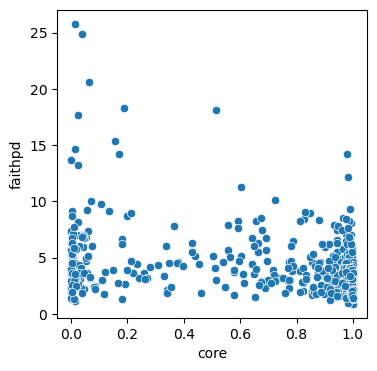

In [139]:
fig, axes = plt.subplots(figsize=(4,4))
bombusMeta['cbin'] = bombusMeta['core'].apply(lambda x: x if x >.01 else 0.005)
sns.scatterplot(data = bombusMeta[['core', 'faithpd']],
                x = 'core', y = 'faithpd', ax = axes)
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(.003)
#plt.axvline(0.007, linestyle = '--', color = 'black')
plt.show()

In [38]:
bombusMeta[['Gammaproteobacteria', 'Alphaproteobacteria',
       'Betaproteobacteria', 'faithpd']].corr()

,Gammaproteobacteria,Alphaproteobacteria,Betaproteobacteria,faithpd
Gammaproteobacteria,1.000000,-0.336257,-0.685417,0.028997
Alphaproteobacteria,-0.336257,1.000000,-0.279985,0.156835
Betaproteobacteria,-0.685417,-0.279985,1.000000,-0.222715
faithpd,0.028997,0.156835,-0.222715,1.000000


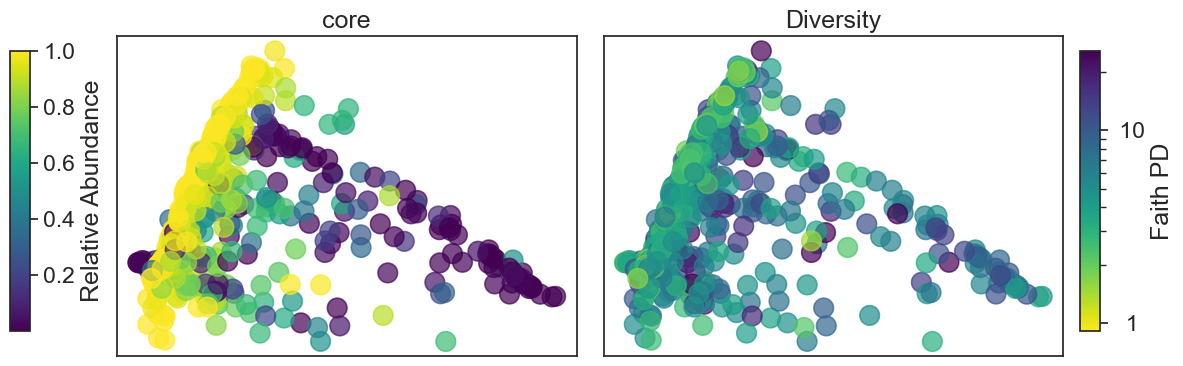

In [76]:
sns.set(style = 'white', font_scale = (1.5))
fig, ax = plt.subplots(1,2, figsize = (10, 4), sharey = True)

sns.scatterplot(data = bombusMeta, x = 'PC1',y = 'PC2',
            c = bombusMeta['core'],
                s = 200, alpha = 0.7, ax = ax[0], edgecolor = None,
               cmap = 'viridis')
p1 = sns.scatterplot(data = bombusMeta, x = 'PC1',y = 'PC2',
            c = bombusMeta['faithpd'].transform(lambda x: np.log(12) if x > 12 else np.log(x)),
                s = 200, alpha = 0.7, ax = ax[1],edgecolor = None, cmap = "viridis_r")
ax[0].set_title('core')
ax[1].set_title('Diversity')

ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("")
ax[0].set_ylabel("")
ax[1].set_xlabel("")


plt.tight_layout()

ax[0].figure.colorbar(plt.cm.ScalarMappable(norm=colors.Normalize(vmin=bombusMeta['core'].min(),
                      vmax=bombusMeta['core'].max()), cmap='viridis'),
                      cax = fig.add_axes([-0.08, .13, .02, .7]),
                     label = 'Relative Abundance')

cbar1 = ax[1].figure.colorbar(plt.cm.ScalarMappable(norm=colors.LogNorm(vmin=bombusMeta['faithpd'].min(),
                      vmax=bombusMeta['faithpd'].max()), cmap='viridis_r'),
                      cax = fig.add_axes([.99, .13, .02, .7]),
                     label='Faith PD', format ="%3.1d")
plt.savefig('figs/gamma_diversity.pdf', transparent = True,
           bbox_inches="tight" )

In [78]:
level6[[x for x in level6.columns if 'Betaproteobacteria' in x]].mean().sort_values()[-5:]

Taxon
d__Bacteria;p__Pseudomonadota;c__Betaproteobacteria;o__Burkholderiales;f__Burkholderiaceae                   0.000149
d__Bacteria;p__Pseudomonadota;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Massilia       0.000493
d__Bacteria;p__Pseudomonadota;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Acidovorax       0.001086
d__Bacteria;p__Pseudomonadota;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Achromobacter    0.003064
d__Bacteria;p__Pseudomonadota;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Snodgrassella        0.271496
dtype: float64

# omnibus testing

## setup data

long format weighted unifrac

In [103]:
wu_diff = pd.melt(pd.DataFrame(np.tril(wu_df),
             columns = wu_df.columns, index = wu_df.index).replace(0,
                np.nan).reset_index(), id_vars = 'index', var_name='b2',
        value_name='wu').dropna()
wu_diff.index = wu_diff['index'] + wu_diff['b2']

difference in collection date 

In [104]:
def getTimeDif(date0, date1):
    d0 = pd.to_datetime(date0)
    d1 = pd.to_datetime(date1)
    delta = d0-d1
    delta = delta.days
    if delta >0:
        return delta
    else:
        return 0-delta

# year removed, for seasonal trneds
bombusMeta['date_no_year'] = bombusMeta['date_of_collection'].apply(lambda x: x[:-2]+'23')   

timedif_same_summer = np.asarray([[getTimeDif(i,j) for j in bombusMeta['date_no_year'].to_numpy()]
                         for i in bombusMeta['date_no_year'].to_numpy()])

timedif_same_summer = pd.DataFrame(timedif_same_summer,
                                   columns=bombusMeta.index, index = bombusMeta.index)
# make long format 
day_difference = pd.melt(pd.DataFrame(np.tril(timedif_same_summer.loc[wu_df.index, wu_df.columns]),
             columns = wu_df.columns, index = wu_df.index).replace(0,
                np.nan).reset_index(), id_vars = 'index', var_name='b2',
        value_name='days').dropna()

day_difference.index = day_difference['index'] + day_difference['b2']

distance in km between samples

In [105]:
# haversine formula
R = 6373.0
def getDistance(pos1, pos2): 
    '''
    gets the distance between two coordinate pairs in km
    takes 2 lat lon pairs and returns a float
    '''
    lat1, lon1 = map(radians, pos1)
    lat2, lon2 = map(radians, pos2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

geodif = np.asarray([[getDistance(i,j) for j in bombusMeta[['Latitude', 'Longitude']].to_numpy()]
                         for i in bombusMeta[['Latitude', 'Longitude']].to_numpy()])

geodif = pd.DataFrame(geodif, columns=bombusMeta.index, index = bombusMeta.index)

# long format
geo_difference = pd.melt(pd.DataFrame(np.tril(geodif.loc[wu_df.index, wu_df.columns]),
             columns = geodif.columns, index = geodif.index).replace(0,
                np.nan).reset_index(), id_vars = 'index', var_name='b2',
        value_name='km').dropna()
geo_difference.index = geo_difference['index'] + geo_difference['b2']

phylogenetic difference in host species

In [106]:
'''
Original data from Cameron et al., 2007
Realignment by @aphanotus/borealis/Bombus.tree on github 
'''
tree = Phylo.read(datapath+"/tree", "newick")
# metadata abbrev -> name in tree
lookup = {'imp': 'B._impatiens', 'vag': 'B._vagans', 'bor':'B._borealis', 
                           'bim':'B._bimaculatus', 'san': 'B._sandersoni', 'fer': 'B._fervidus',
                           'ruf': 'B._rufocinctus', 'tern':'B._ternarius', 'per': 'B._perplexus',
                           'terri':'B._terricola', 'gris':'B._griseocollis' }
# make dataframe
dm_host = np.asarray([[tree.distance(lookup[i],lookup[j]) for j in bombusMeta['species']]
                      for i in bombusMeta['species']])
dm_host = pd.DataFrame(dm_host, columns = bombusMeta.index, index = bombusMeta.index)


phylo_difference = pd.melt(pd.DataFrame(np.tril(dm_host.loc[wu_df.index, wu_df.columns]),
             columns = dm_host.columns, index = dm_host.index).replace(0,
                np.nan).reset_index(), id_vars = 'index', var_name='b2',
        value_name='branch lengths').dropna()
phylo_difference.index = phylo_difference['index'] + phylo_difference['b2']

## plot against weighted unifrac

promising looking trend for collection date!

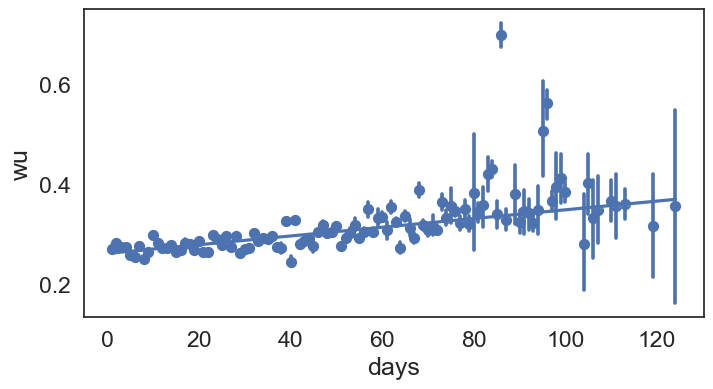

In [83]:
fig, ax = plt.subplots(figsize = (8,4))
sns.regplot(data = day_difference[['days']].join(wu_diff[['wu']]),
                x = 'days', y = 'wu', x_estimator=np.mean)
plt.savefig('figs/wu_days_regplot.pdf', transparent = True, bbox_inches='tight')

geographic distance between sites

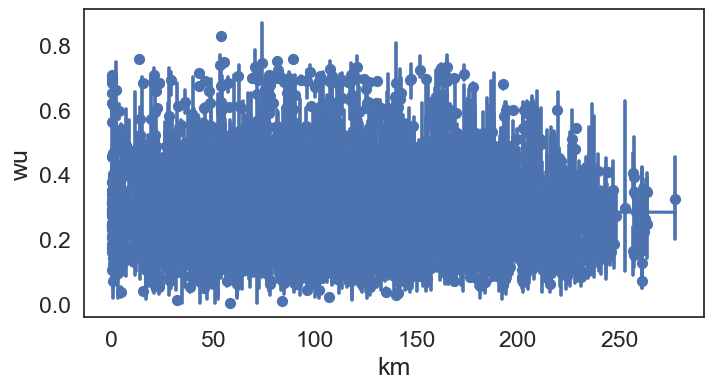

In [84]:
fig, ax = plt.subplots(figsize = (8,4))
sns.regplot(data = geo_difference[['km']].join(wu_diff[['wu']]),
                x = 'km', y = 'wu', x_estimator=np.mean)
plt.savefig('figs/wu_km_regplot.pdf', transparent = True, bbox_inches='tight')

phylogenetic difference between hosts

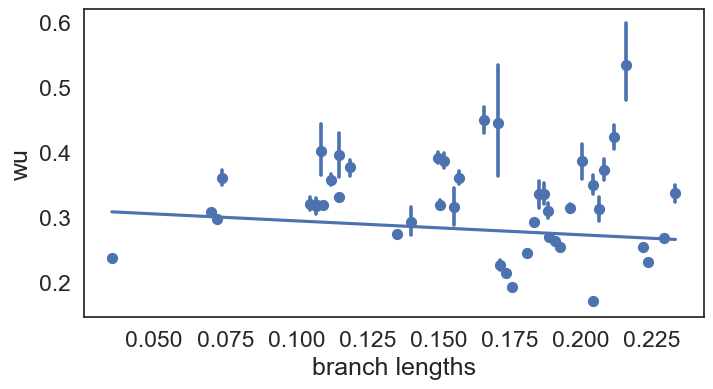

In [85]:
fig, ax = plt.subplots(figsize = (8,4))
sns.regplot(data = phylo_difference[['branch lengths']].join(wu_diff[['wu']]),
                x = 'branch lengths', y = 'wu', x_estimator=np.mean)
plt.savefig('figs/wu_phylo_regplot.pdf', transparent = True, bbox_inches='tight')

## use ADONIS to test for variation between catagories

additional setup

In [107]:
%load_ext rpy2.ipython

In [192]:
bombusMeta['Month'] = bombusMeta['date_of_collection'].apply(lambda x: x.split('/')[0]).apply(lambda x:\
        {'5': 'May', '6': 'June','7': 'July', '8': 'August', '9': 'September'}[x])

bombusMeta['site_trip'] = bombusMeta['site_collapsed'] + bombusMeta['date_of_collection']
bombusMeta['site_year'] = bombusMeta['site_collapsed'] + bombusMeta['Year']

adonisdata = bombusMeta[['species', 'caste', 'site_collapsed', 'Year',
                        'site_trip', 'Month', 'site_year']].dropna().copy()

# get rid of missing sites 
adonisdata.drop(adonisdata[adonisdata['site_trip'].str.contains('No_Site')].index,
                inplace=True)
wu_df = wu_df.loc[adonisdata.index, adonisdata.index]

**ADONIS2**: implementation of permanova in r. Allows for marginal effect testing.

Covariates: host species, host caste, site x year interaction (to capture local population), month (to capture seasonality)

In [193]:
%%R -i adonisdata,wu_df
library(vegan)

adonis2(wu_df ~ species +  site_year + Month + caste, data = adonisdata,
       by = 'margin')

Permutation test for adonis under reduced model
Marginal effects of terms
Permutation: free
Number of permutations: 999

adonis2(formula = wu_df ~ species + site_year + Month + caste, data = adonisdata, by = "margin")
           Df SumOfSqs      R2      F Pr(>F)    
species     9    2.221 0.06892 5.8990  0.001 ***
site_year  87    5.639 0.17499 1.5495  0.001 ***
Month       4    0.476 0.01476 2.8427  0.002 ** 
caste       2    0.199 0.00617 2.3756  0.017 *  
Residual  520   21.752 0.67501                  
Total     622   32.225 1.00000                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [90]:
bombusMeta['site_year'].unique().shape

(90,)

### plot sig results on weighted unifrac pcoa

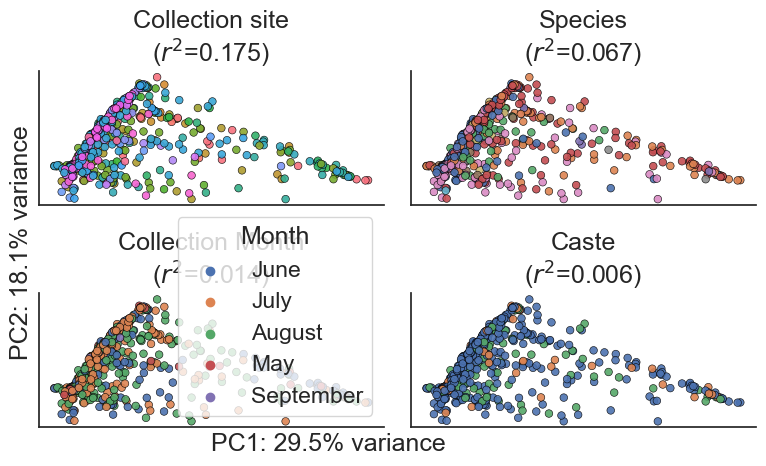

In [87]:
fig, ax = plt.subplots(2,2, figsize = (8,5), sharex = True, sharey = True)
ax[1,0].set_xlabel('PC1: 29.5% variance', ha='left')
ax[1,0].set_ylabel('PC2: 18.1% variance', ha='left')
ax[0,0].set_ylabel(' ')


sns.scatterplot(data = bombusMeta, x = 'PC1',y = 'PC2',
            hue = bombusMeta['site_year'],
                s = 30, alpha = 0.9, ax = ax[0,0], edgecolor='black', legend = False)
ax[0,0].set_title('Collection site\n($r^2$=0.175)')

sns.scatterplot(data = bombusMeta, x = 'PC1',y = 'PC2',
            hue = bombusMeta['species'],
                s = 30, alpha = 0.9, ax = ax[0,1], edgecolor='black', legend = False)
ax[0,1].set_title('Species\n($r^2$=0.067)')

sns.scatterplot(data = bombusMeta, x = 'PC1',y = 'PC2',
            hue = bombusMeta['Month'],
                s = 30, alpha = 0.9, ax = ax[1,0], edgecolor='black', legend = True)
ax[1,0].set_title('Collection Month\n($r^2$=0.014)')

sns.scatterplot(data = bombusMeta, x = 'PC1',y = 'PC2',
            hue = bombusMeta['caste'],
                s = 30, alpha = 0.9, ax = ax[1,1], edgecolor='black', legend = False)

# ax[1,1].legend(fontsize='small')
# ax[1,0].legend(fontsize='small')
# ax[0,1].legend(fontsize='small')
# sns.move_legend(ax[1,1], loc = 'upper right', bbox_to_anchor = (1,1.5))
# sns.move_legend(ax[0,1], loc = 'upper right', bbox_to_anchor = (2,2))


ax[1,1].set_title('Caste\n($r^2$=0.006)')
ax[1,1].set_xlabel(' ')

ax[0,0].set_yticks([])
ax[0,1].set_yticks([])
ax[1,0].set_xticks([])
ax[1,1].set_xticks([])

sns.despine()
plt.tight_layout()

plt.savefig('figs/all_pca.no_legends.pdf', transparent = True, bbox_inches='tight')


## Mantel tests for correlations with quantitative data

**geo**

In [109]:
geosamps = bombusMeta[bombusMeta['Longitude'].isna()==False].index
mantel(geodif.loc[geosamps, geosamps],
                            wu_df.loc[geosamps, geosamps], 'spearman', 999)

(-0.0020051368251376256, 0.905, 563)

**phylogeny**

In [110]:
mantel(dm_host.loc[wu_df.index, wu_df.index],
                            wu_df, 'spearman', 999)

(-0.014013111899175746, 0.556, 638)

**collection date**

In [111]:
mantel(timedif_same_summer.loc[wu_df.index, wu_df.index], wu_df, 'spearman', 999)

(0.10122592041186915, 0.001, 638)

**collection date, controlling for same trip**

use the vegan implementation of the mantel test for significance testing
- significance is estimated as the proportion of permuted matrices with equal or stronger correlations than the original
- permuting within site_trip controls for the correlation between site effect and a date difference of zero

In [196]:
bombusMeta['site_collapsed'].value_counts().sort_values().iloc[-15:]

site_collapsed
Ellsworth_ME              9
Stratton_ME               9
Blue Mountain             9
Coast_Port_Clyde_ME       9
MDI_Northeast_Harbor     10
MDI_Southwest_Harbor     11
Kingfield_ME             12
Hancock_ME               12
No_Site                  15
Monhegan_Island          17
Great_Wass_Island        25
Vinalhaven_ME            26
Swans_Island_ME          41
Colby_College           103
Allen_Island            148
Name: count, dtype: int64

In [207]:

strata = bombusMeta[~bombusMeta['site_year'].str.contains('No_Site')]['site_year']

timedif_same_summer = timedif_same_summer.loc[wu_df.index, wu_df.index]

rtimedif = timedif_same_summer.copy()
rstrata = strata.copy()
rwu = wu_df.copy()

rtimedif.index = ['x' + x for x in timedif_same_summer.index]
rtimedif.columns = ['x' + x for x in timedif_same_summer.columns]
rstrata.index = ['x' + x for x in strata.index]
rwu.index = ['x' + x for x in wu_df.index]
rwu.columns = ['x' + x for x in wu_df.columns]
samps = list(set(rstrata.index).intersection(rtimedif.index).intersection(rwu.index))
rstrata = rstrata[samps]
rwu = rwu.loc[samps, samps]
rtimedif = rtimedif.loc[samps,samps]

In [212]:
[x for x in level6.columns if 'gbxid5846' in x]

['d__Bacteria;p__Bacillota;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__gbxid5846']

In [208]:
%%R -i rtimedif,rwu,rstrata


mantel(rtimedif, rwu, method='spearman',  strata=rstrata, permutations = 999)


Mantel statistic based on Spearman's rank correlation rho 

Call:
mantel(xdis = rtimedif, ydis = rwu, method = "spearman", permutations = 999,      strata = rstrata) 

Mantel statistic r: 0.09734 
      Significance: 0.001 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0527 0.0570 0.0620 0.0647 
Blocks:  strata 
Permutation: free
Number of permutations: 999



# save updated metadata

In [95]:
bombusMeta.to_csv(os.path.join(datapath, 'bombusMetadata.tsv'), sep = '\t')

save the host dm too

In [96]:
dm_host.to_csv(os.path.join(datapath,'dm', 'dm_host.tsv'), sep = '\t')